<a href="https://colab.research.google.com/github/souken-b/calc_OWC/blob/main/calc_pulsating_pres_with_correction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1820]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

In [1821]:
global p_air, dens_air, h_ratio
T = 3 # 周期
n = 10000 # 分割数
#############
# n_diam = 0.008123 # オリフィス直径(m)
# D0 = 0.0254 # 円管の直径(m)
# A = 5.1823028331816915 * 1e-05 # オリフィスの断面積(m2)
# A0 = np.pi * ((D0 / 2) ** 2) # 円管の断面積(m2)
# L0 = 0.12 # t=0での空気室高さ(m)
# # L0 = 0.15830000000000002 # ピストンロッドの長さ(m)
# L = 0.08 # ピストン変位振幅(m)
# d_ratio = n_diam / D0 # 絞り直径比
# n_ratio = d_ratio ** 2 # 絞り面積比
##############
n_diam = 0.035 # オリフィス直径(m)
D0 = 0.5 # 円管の直径(m)
A = 0.00096211275 # オリフィスの断面積(m2)
A0 = 0.19242255 # 円管の断面積(m2)
L0 = 0.625 # t=0での空気室高さ(m)
L = 0.032 # ピストン変位振幅(m)
d_ratio = n_diam / D0 # 絞り直径比
n_ratio = d_ratio ** 2 # 絞り面積比
###############
h_ratio = 1.4 # 比熱比
p_air = 101325 # 大気圧(pa)
dens_air = 1.225 # 空気の密度(kg/m3)

In [1822]:
L_h = 0.02750688
L_h_0 = 0.625
phase_diff = 0

In [1823]:
def calc_density(p0):
  dens0 = dens_air * ((p0 / p_air) ** (1/h_ratio))
  return dens0

In [1824]:
def c_ci(d_ratio)->'非圧縮性の縮流係数':
  # flow coefficient
  f_coef = 0.598 - 0.003 * (d_ratio ** 2) + 0.404 * (d_ratio ** 4)
  return (f_coef / ((1 + (d_ratio ** 4) * (f_coef ** 2)) ** (1/2)))

In [1825]:
def force_ci(c_ci)->'非圧縮性力欠損係数':
  return ((1 / c_ci) - (1 / (2 * (c_ci ** 2))))

In [1826]:
def c_c(f_ci_c, p_up, p_down)->'圧縮性の縮流係数':
  p_ratio = p_up / p_down
  h_ratio_rev = 1/ h_ratio
  return ((1 / (2 * f_ci_c)) * (p_ratio ** h_ratio_rev) * (1 - (1 - ((2 * f_ci_c * (1 - h_ratio_rev)) * (1 - (1 / p_ratio)) / (1- (p_ratio) ** (h_ratio_rev - 1))))  ** (1/2)))

In [1827]:
def forward_calc_p_delta(p0_prev, p0_current, f_ci_c, h, dens0_prev, dens0_current, dV0dt, dV02dt2, A, A0):
  if (p0_prev > p_air):
    c_c_c_prev = c_c(f_ci_c, p0_prev, p_air)
    flow_prev = forward_flow(c_c_c_prev, A, p0_prev, dens0_prev)
  else:
    c_c_c_prev = c_c(f_ci_c, p_air, p0_prev)
    flow_prev = (-1) * back_flow(c_c_c_prev, A, p0_prev)
  
  c_c_c_current = c_c(f_ci_c, p0_current, p_air)
  flow_current = forward_flow(c_c_c_current, A, p0_current, dens0_current)
  p_delta = forward_delta_p0(dens0_current, dV0dt, dV02dt2, flow_prev, flow_current, h, A0)
  return p_delta


In [1828]:
def back_calc_p_delta(p0_prev, p0_current, f_ci_c, h, dens0_prev, dens0_current, dV0dt, dV02dt2, A, A0):
  if (p0_prev > p_air):
    c_c_c_prev = c_c(f_ci_c, p0_prev, p_air)
    flow_prev = forward_flow(c_c_c_prev, A, p0_prev, dens0_prev)
  else:
    c_c_c_prev = c_c(f_ci_c, p_air, p0_prev)
    flow_prev = (-1) * back_flow(c_c_c_prev, A, p0_prev)

  c_c_c_current = c_c(f_ci_c, p_air, p0_current)
  flow_current = (-1) * back_flow(c_c_c_current, A, p0_current)
  p_delta = back_delta_p0(dens0_current, dV0dt, dV02dt2, flow_prev, flow_current, h, A0)
  return p_delta

In [1829]:
def runge_kutta(t_interval, t_list, c_freq, p_list, V0_list, dV0dt_list, dV02dt2_list, T, d_ratio, A0, A, f_ci_c, L_h, L_h_0, phase_diff, p_delta_list):
  t = t_list
  p = p_list
  V0 = V0_list
  p_delta = p_delta_list
  dV0dt = dV0dt_list
  dV02dt2 = dV02dt2_list
  h = t_interval


  # 方程式を解くための反復計算
  for i in range(len(t) -1):
    #######runge-kutta法により圧力を計算#######
    arg_list = [T, d_ratio, V0[i], dV0dt[i], A, f_ci_c] # dpdtの引数
    k_1 = h * dpdt(p[i], t[i], *arg_list)
    k_2 = h * dpdt(p[i] + k_1 / 2 , t[i] + h/2, *arg_list)
    k_3 = h * dpdt(p[i] + k_2 / 2 , t[i] + h/2, *arg_list)
    k_4 = h * dpdt(p[i] + k_3, t[i] + h, *arg_list)
    p[i+1] = p[i] + 1/6 * (k_1 + 2 * k_2 + 2 * k_3 + k_4)
    #####################################

    V0[i+1] = (L_h_0 + L_h * np.cos(c_freq * t[i] + phase_diff)) * A0

    ########圧力勾配を計算##################
    dV0dt[i+1] = ((-1) * c_freq * L_h * np.sin(c_freq * t[i] + phase_diff)) * A0
    dV02dt2[i+1] = ((-1) * ((c_freq) ** 2) * L_h * np.cos(c_freq * t[i] + phase_diff)) * A0

    dens0_prev = calc_density(p[i])
    dens0_current = calc_density(p[i+1])

    arg_list_2 = [p[i], p[i+1], f_ci_c, h, dens0_prev, dens0_current, dV0dt[i+1], dV02dt2[i+1], A, A0] # calc_p_deltaの引数
    p_delta[i+1] = forward_calc_p_delta(*arg_list_2) if (p[i+1] > p_air) else back_calc_p_delta(*arg_list_2)
    #####################################

    # pがnanの場合はbreakさせる
    if (np.isnan(p[i+1])):
      break

  return t, p, V0, p_delta

In [1830]:
def calc_state(n, T, d_ratio, A0, A, f_ci_c, L_h, L_h_0, phase_diff):
  h = T / n
  t = np.arange(0, T, h)
  c_freq = 2 * np.pi / T
  total_split = len(t)
  p, V0, dV0dt, dV02dt2, p_delta = [np.empty(total_split) for i in range(5)]
  p[0], p_delta[0] = p_air + 10, 20
  V0[0], dV0dt[0], dV02dt2[0] = (L_h_0 + L_h * np.cos(phase_diff)) * A0, ((-1) * c_freq * L_h * np.sin(phase_diff)) * A0, ((-1) * ((c_freq) ** 2) * L_h * np.cos(phase_diff)) * A0

  t, p, V0, p_delta = runge_kutta(h, t, c_freq, p, V0, dV0dt, dV02dt2, T, d_ratio, A0, A, f_ci_c, L_h, L_h_0, phase_diff, p_delta)
  
  return t, p, V0, p_delta

In [1831]:
def forward_flow(c_c_c, A, p_up, dens_up)->'押出流量':
  h_ratio_rev = 1 / h_ratio
  return  (dens_up / dens_air) * (c_c_c * A  * ((p_up / p_air) ** (-1 * h_ratio_rev)) * (((2 / (1 - h_ratio_rev)) * (p_up / dens_up) * (1 - (p_up / p_air) ** (h_ratio_rev - 1))) ** (1 / 2)))

In [1832]:
def back_flow(c_c_c, A, p_down)->'吸込流量':
  h_ratio_rev = 1 / h_ratio
  return  c_c_c * A  * ((p_air / p_down) ** (-1 * h_ratio_rev)) * (((2 / (1 - h_ratio_rev)) * (p_air / dens_air) * (1 - (p_air / p_down) ** (h_ratio_rev - 1))) ** (1 / 2))

In [1833]:
def forward_delta_p0(dens0, dV0dt, dV02dt2, flow_prev, flow_current, delta_t, A0)->'押出圧力補正':
  flow_diff = (flow_current - flow_prev) / delta_t
  delta_p0 = (-1) * ((dens0 ** 2) / (A0 ** 2)) * (dV02dt2 + (dens_air / dens0) * flow_diff + (1 / 2) * (dV0dt + (1 / dens0) * (dens_air * flow_current)) * dV0dt)
  return delta_p0

In [1834]:
def back_delta_p0(dens0, dV0dt, dV02dt2, flow_prev, flow_current, delta_t, A0)->'吸込圧力補正':
  flow_diff = (flow_current - flow_prev) / delta_t
  delta_p0 = (-1) * ((dens0 ** 2) / (A0 ** 2)) * (dV02dt2 + ((7/2) * ((dens_air / dens0) ** h_ratio) * (flow_diff)) - ((5/2) * (dens_air / dens0) * (flow_diff)) + (1/2) * (dV0dt + ((1 / 2) * ((7 * ((dens_air / dens0) ** (h_ratio + 1))) - 5) * ( 1 / dens0) * (dens_air * flow_current))) * dV0dt)
  return delta_p0

In [1835]:
def dpdt(p0, t, T, d_ratio, V0, dV0dt, A, f_ci_c)->'圧力変化':
  # 円振動数ω
  c_freq = 2 * np.pi / T
  h_ratio_rev = 1 / h_ratio
  dens0 = dens_air * ((p0 / p_air) ** (h_ratio_rev))
  if (p0 > p_air):
    c_c_c = c_c(f_ci_c, p0, p_air)
    flow = forward_flow(c_c_c, A, p0, dens0)
    dpdt = (-7/5) * p0 * ((dV0dt / V0) + ((dens_air / dens0) * (flow / V0)))
  else:
    c_c_c = c_c(f_ci_c, p_air, p0)
    flow = back_flow(c_c_c, A, p0)
    dpdt = (-7/5) * p0 * ((dV0dt / V0) + (((dens_air / dens0) ** h_ratio) * (((-1) * flow) / V0)))
  return dpdt

In [1836]:
c_ci_c = c_ci(d_ratio)
f_ci_c = force_ci(c_ci_c)
result = calc_state(n, T, d_ratio, A0, A, f_ci_c, L_h, L_h_0, phase_diff)
t_list, p_list, v0_list, p_delta_list = result

In [1837]:
p_air_list = [p_air] * len(p_list)
p_list_diff = p_list - p_air_list

In [1838]:
p_list_correct = p_list + p_delta_list

In [1839]:
def calc_flow(f_ci_c, p_list):
  flow_list = []
  for p0 in p_list:
    dens0 = dens_air * ((p0 / p_air) ** (1/h_ratio))
    if (p0 > p_air):
      c_c_c = c_c(f_ci_c, p0, p_air)
      flow = forward_flow(c_c_c, A, p0, dens0)
    else:
      c_c_c = c_c(f_ci_c, p_air, p0)
      flow = (-1) * back_flow(c_c_c, A, p0)
    flow_list.append(flow)
  return flow_list


In [1840]:
flow = calc_flow(f_ci_c, p_list)
flow_correct = calc_flow(f_ci_c, p_list_correct)

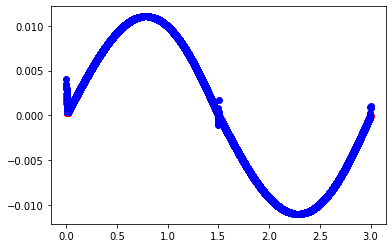

In [1841]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(t_list, flow, c='red')
ax.scatter(t_list, flow_correct, c='blue')
plt.show()

In [1842]:
p_list_diff = p_list - p_air_list
p_list_diff_correct = p_list_correct - p_air_list

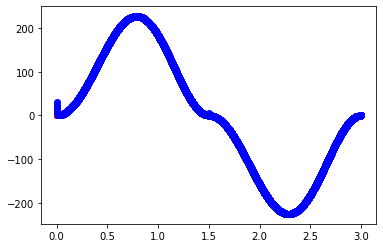

In [1843]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(t_list, p_list_diff, c='red')
ax.scatter(t_list, p_list_diff_correct, c='blue')
plt.show()

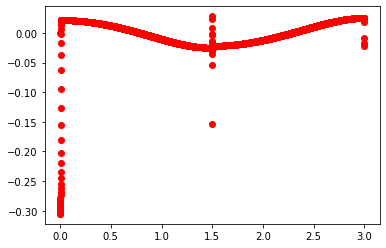

In [1844]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(t_list, flow_diff, c='red')
plt.show()

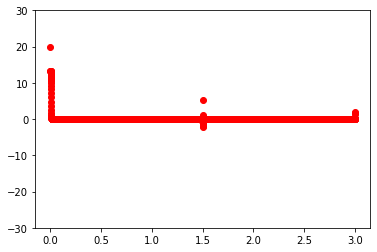

In [1845]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(t_list, p_delta_list, c='red')
plt.ylim(-30, 30)
plt.show()